В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_1):
        W1 = np.random.randn(n_1, n_x) * 0.01
        b1 = np.zeros((n_1, 1))
        W2 = np.random.randn(1, n_1) * 0.01
        b2 = 0 # у вихідному шарі лише 1 нейрон
        self.parameters = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
       
    def __forward_propagation(self, X):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        Z1 = np.dot(W1, X) + b1
        A1 = self.__sigmoid(Z1)

        Z2 = np.dot(W2, A1) + b2
        A2 = self.__sigmoid(Z2)

        
        cache = (W1, b1, W2, b2, Z1, A1, Z2, A2)

        return A2, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W1, b1, W2, b2, Z1, A1, Z2, A2) = cache
        
        dZ2 = A2 - Y
        dW2 = 1. / m * np.dot(dZ2, A1.T)
        db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
        
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.multiply(dA1, np.multiply(A1, 1 - A1))
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        

        grads = {"dZ1" : dZ1, "dW1" : dW1, "db1" : db1, "dZ2" : dZ2, "dW2" : dW2, "db2" : db2}
        return grads
    
    def __update_parameters(self, grads):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        

        self.parameters["W1"] = W1 - self.learning_rate * dW1
        self.parameters["b1"] = b1 - self.learning_rate * db1
        self.parameters["W2"] = W2 - self.learning_rate * dW2
        self.parameters["b2"] = b2 - self.learning_rate * db2

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x, 20)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


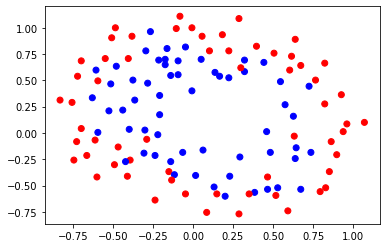

In [7]:
plot_data(X, Y)

In [8]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000)

0-th iteration: 0.6930620533710502
1000-th iteration: 0.6901557652892701
2000-th iteration: 0.6740578219741026
3000-th iteration: 0.5795189173000207


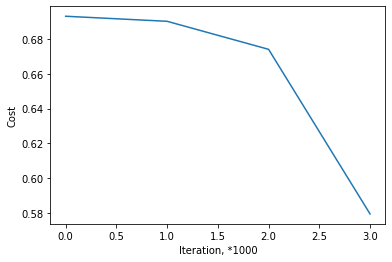

In [9]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [10]:
print(cls.parameters)

{'W1': array([[-1.22323891e+00,  3.73128929e-01],
       [-8.44265936e-01, -4.17067300e-02],
       [-6.55803465e-01,  9.71615626e-02],
       [ 1.02148524e+00, -2.56105756e+00],
       [-3.65341922e-01,  5.98542218e-03],
       [-6.53413438e-01,  6.47761188e-02],
       [-3.74190625e-01, -4.28468249e-03],
       [-1.26551235e+00,  3.56843393e-01],
       [-3.49621524e+00, -2.89062392e+00],
       [-1.67161550e+00,  4.91498397e-01],
       [ 5.02614677e-02, -9.96121133e-01],
       [ 4.62264438e-02, -2.73345164e+00],
       [-1.90176827e-01,  3.38419421e-02],
       [-1.46553709e+00,  4.82957565e-01],
       [-3.61588209e-01,  8.27257515e-03],
       [-6.95414110e-01,  8.90066739e-02],
       [-1.58680551e+00,  4.55142034e-01],
       [-1.80931408e+00,  2.69493288e-01],
       [-5.72986851e-01,  3.27883425e-02],
       [-3.58828801e-01,  1.25678271e-03]]), 'b1': array([[-0.97904291],
       [-0.63397516],
       [-0.40022573],
       [-2.8642385 ],
       [-0.12162356],
       [-0.4028

In [11]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.50104294, 0.49895706],
       [0.64361626, 0.35638374],
       [0.21146422, 0.78853578],
       [0.26118734, 0.73881266],
       [0.20979647, 0.79020353],
       [0.82230018, 0.17769982],
       [0.12893761, 0.87106239],
       [0.36406651, 0.63593349],
       [0.83115118, 0.16884882],
       [0.85297129, 0.14702871],
       [0.9370799 , 0.0629201 ],
       [0.44263078, 0.55736922],
       [0.28399028, 0.71600972],
       [0.23375692, 0.76624308],
       [0.75292525, 0.24707475],
       [0.3505815 , 0.6494185 ],
       [0.37672585, 0.62327415],
       [0.76080544, 0.23919456],
       [0.63171002, 0.36828998],
       [0.26777515, 0.73222485],
       [0.94934448, 0.05065552],
       [0.73599255, 0.26400745],
       [0.56421518, 0.43578482],
       [0.14426796, 0.85573204],
       [0.36660337, 0.63339663],
       [0.78409551, 0.21590449],
       [0.28470591, 0.71529409],
       [0.51669448, 0.48330552],
       [0.38096826, 0.61903174],
       [0.68586857, 0.31413143],
       [0.

In [12]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [13]:
accuracy_score(Y, Y_hat)

0.8220338983050848

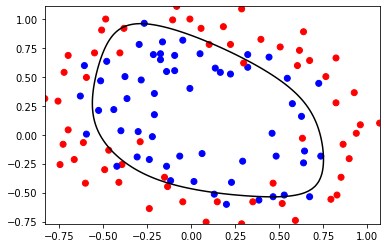

In [14]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [16]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(20,), max_iter=10000)

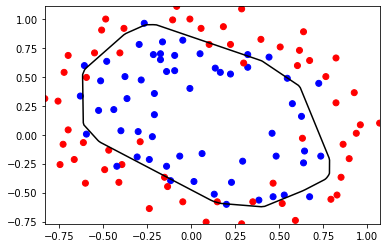

In [17]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [18]:
accuracy_score(Y, clf.predict(X))

0.8305084745762712

In [19]:
clf.n_iter_

1457